# Урок 5. Случайный лес

### 1) Формирования выборки - bootstrap
![bootstrap.jpg](img/bootstrap.jpg)


### 2) Построение композиции алгоритмов - bagging
![bagging.png](img/bagging.png)  


### Random Forest == bagging на решающих деревьях

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

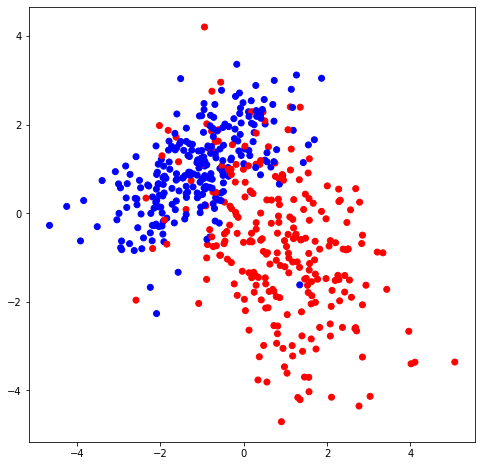

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Повторим реализацию построения дерева решений из предыдущего урока

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [6]:
random.seed(42)

def get_bootstrap(data, labels, N):
    
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))
    return bootstrap

In [7]:
def get_subsample(len_sample):
    
    sample_indexes = [i for i in range(len_sample)]
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    random.shuffle(sample_indexes)
    for i in range(len_subsample):
        subsample.append(sample_indexes.pop())
    
    return subsample

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [13]:
def random_forest(data, labels, n_trees):
    forest=[]     
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

### Предсказание голосованием деревьев

In [16]:
def tree_vote(forest, data):
    
    predictions = []
    voted_predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    pred_per_object = list(zip(*predictions))
    for obj in pred_per_object:
        voted_predictions.append(max(set(obj), key = obj.count))
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее.

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Тест самописного случайного леса

### Домашнее задание
    Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote).
    Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
    Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag (*).
    (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy (*).



In [23]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=500,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5000)

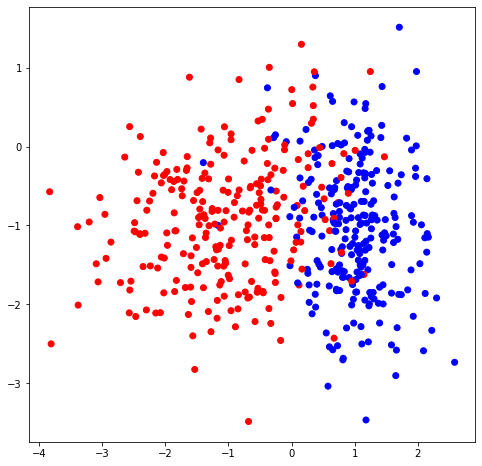

In [24]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [31]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

accrc = []

In [32]:
n_trees = 1
my_forest1 = random_forest(train_data, train_labels, n_trees)

In [33]:
train_answ = tree_vote(my_forest1, train_data)
train_acc = accuracy_metric(train_labels, train_answ)
print(n_trees, train_acc)
test_answ = tree_vote(my_forest1, test_data)
test_acc = accuracy_metric(test_labels, test_answ)
print(n_trees, test_acc)
accrc.append([train_acc, test_acc])

1 92.28571428571428
1 83.33333333333334


1 93.33333333333333


In [42]:
n_trees = 3
my_forest3 = random_forest(train_data, train_labels, n_trees)
train_answ = tree_vote(my_forest3, train_data)
train_acc = accuracy_metric(train_labels, train_answ)
print(n_trees, train_acc)
test_answ = tree_vote(my_forest3, test_data)
test_acc = accuracy_metric(test_labels, test_answ)
print(n_trees, test_acc)
accrc.append([train_acc, test_acc])

3 96.57142857142857
3 87.33333333333333


In [39]:
n_trees = 10
my_forest10 = random_forest(train_data, train_labels, n_trees)
train_answ = tree_vote(my_forest3, train_data)
train_acc = accuracy_metric(train_labels, train_answ)
print(n_trees, train_acc)
test_answ = tree_vote(my_forest3, test_data)
test_acc = accuracy_metric(test_labels, test_answ)
print(n_trees, test_acc)
accrc.append([train_acc, test_acc])

10 96.57142857142857
10 87.33333333333333


In [43]:
n_trees = 50
my_forest50 = random_forest(train_data, train_labels, n_trees)
train_answ = tree_vote(my_forest3, train_data)
train_acc = accuracy_metric(train_labels, train_answ)
print(n_trees, train_acc)
test_answ = tree_vote(my_forest3, test_data)
test_acc = accuracy_metric(test_labels, test_answ)
print(n_trees, test_acc)
accrc.append([train_acc, test_acc])

50 96.57142857142857
50 87.33333333333333


In [47]:
forests = [my_forest1, my_forest3, my_forest10, my_forest50]
trees = [1, 3, 10, 50]

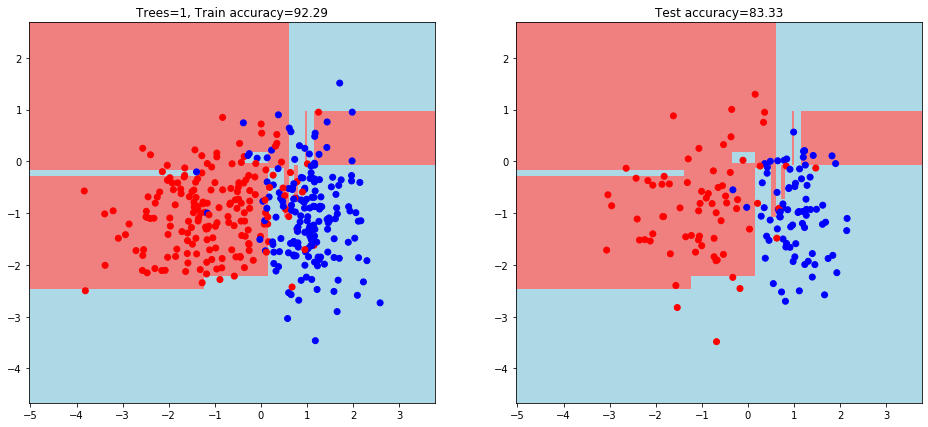

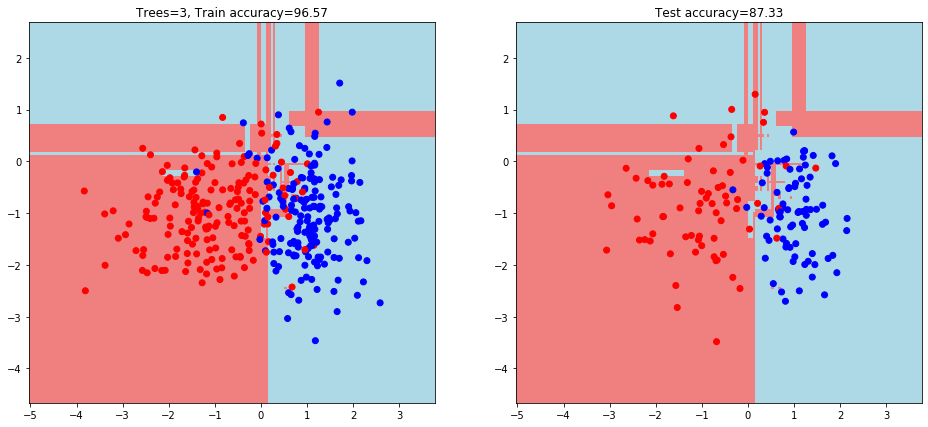

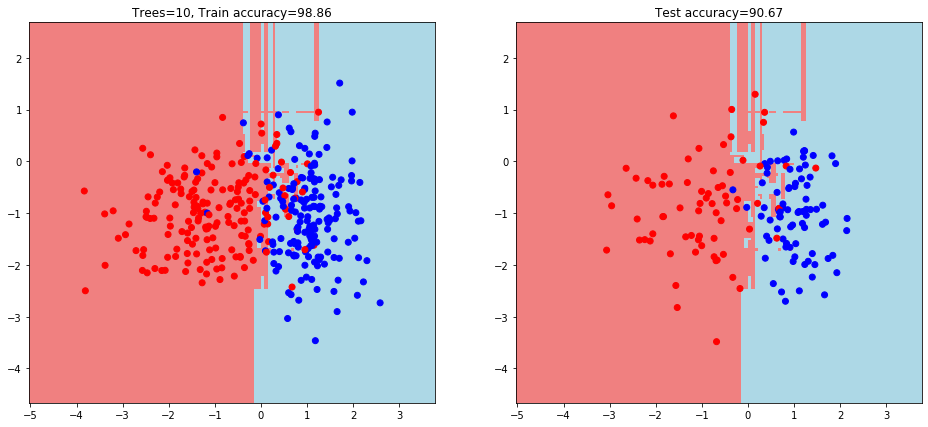

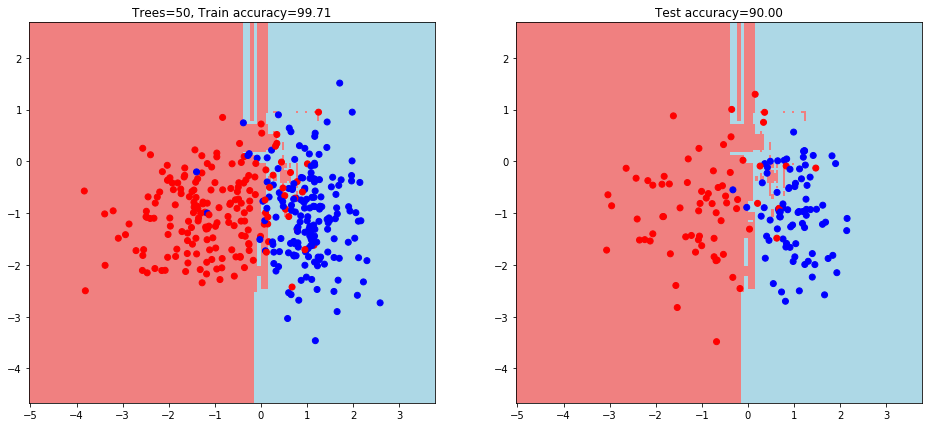

In [56]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


for forest in forests:
    # график обучающей выборки
    plt.figure(figsize = (16, 7))
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Trees={trees[forests.index(forest)]}, Train accuracy={accrc[forests.index(forest)][0]:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={accrc[forests.index(forest)][1]:.2f}')

2. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag. 

In [57]:
random.seed(42)

def get_bootstrap(data, labels, N):
    
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            bootstrap.append((b_data, b_labels))
    return bootstrap

def get_bootstrap(data, labels, N, oob_score):
    
    random.seed(42)
    n_samples = data.shape[0]
    bootstrap = []
    oob_examples = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        ids = []
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            ids.append(sample_index)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            
        bootstrap.append((b_data, b_labels))
        
        if oob_score:
            oob_ids = [idx for idx in range(n_samples) if idx not in set(ids)]
            oob_data = data[oob_ids]
            oob_labels = labels[oob_ids]
            oob_examples.append((oob_data, oob_labels))
        
    return bootstrap, oob_examples

In [58]:
def random_forest(data, labels, n_trees, oob_score=False):
    forest = []
    bootstrap, oob_examples = get_bootstrap(data, labels, n_trees, oob_score=oob_score)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    if oob_score:
        oob_acc = 0
        for i in range(n_trees):
            oob_acc += calc_oob_acc(oob_examples[i], forest[i])
        
        oob_acc = oob_acc / n_trees
        return forest, oob_acc
    
    return forest

In [59]:
def calc_oob_acc(oob_examples, tree):
    oob_answers = predict(oob_examples[0], tree)
    oob_acc = accuracy_metric(oob_examples[1], oob_answers)
    return oob_acc

In [63]:
n_trees = 10
my_forest, oob_score = random_forest(train_data, train_labels, n_trees, oob_score=True)
oob_score

84.11284986118353

3. (На повторение) Переписать функцию calc_gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в calc_entropy (*). 

In [ ]:
def calc_entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    H = 0
    for label in classes:
        p = classes[label] / len(labels)
        H += p * np.log2(p)
        
    return -H